# Getting Started in Machine Learning
### Chapter 8: Nonlinear Regression
This notebook contains examples from the book:

Getting Started in Machine Learning: Easy Recipes for Python 3, Scikit-Learn, Jupyter (2019) by Bella Romeo, Sherwood Forest Books, Los Angeles, CA, USA, ISBN-13: 978-0-9966860-6-8

(c) Copyright 2019.

<font style="font-size:xx-small; font-family:courier;">

    This notebook is free software: you can redistribute it and/or modify
    it under the terms of the GNU General Public License as published by
    the Free Software Foundation, either version 3 of the License, or
    (at your option) any later version.

    This program is distributed in the hope that it will be useful,
    but WITHOUT ANY WARRANTY; without even the implied warranty of
    MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
    GNU General Public License for more details.

    You should have received a copy of the GNU General Public License
    along with this program. If not, see <https://www.gnu.org/licenses/>.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
%matplotlib inline

## Hill Function, Generate Toy Data Set

In [2]:
def fhill(x,a=1,n=1):
    return x**n/(a**n+x**n)

In [3]:
XHILL=np.linspace(0,5,50)
atarget=2.5; ntarget=4
YHILL=fhill(XHILL,atarget,ntarget)
n=25
np.random.seed(99)
xs=np.linspace(0,5,n)
ys=fhill(xs,atarget,ntarget)+np.random.normal(0,.1,n)
x,y=np.array([(x,y) for (x,y) in zip (xs,ys) if y>0]).T
n=len(x)
print("There are",n,"data points")

There are 23 data points


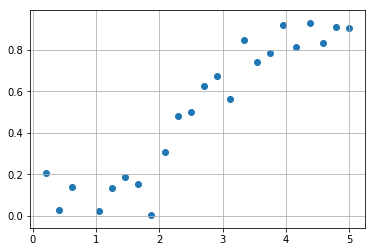

In [4]:
#plt.plot(XHILL,YHILL)
plt.scatter(x,y)
plt.grid()
#plt.savefig("hill-function-toy-data.pdf")

In [5]:
parameters,covmatrix=curve_fit(fhill,x,y,p0=(1,1))

In [6]:
afit,nfit=parameters
asig,nsig = np.sqrt(np.diag(covmatrix))
print("Predicted a = ",round(afit,2),"+/-",round(1.96*asig,2))
print("Predicted n = ",round(nfit,2),"+/-",round(1.96*nsig,2))

Predicted a =  2.54 +/- 0.17
Predicted n =  3.87 +/- 0.93


In [7]:
covmatrix

array([[0.00762362, 0.00992891],
       [0.00992891, 0.22447413]])

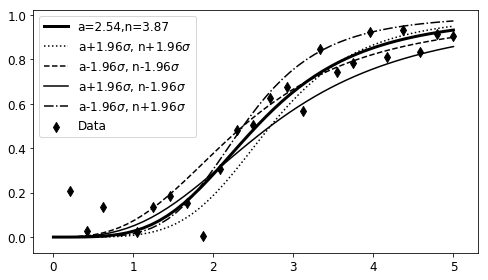

In [8]:
plt.plot(XHILL, fhill(XHILL,afit,nfit),c="k",lw=3,label="a="+str(round(afit,2))+",n="+str(round(nfit,2)))
plt.plot(XHILL, fhill(XHILL, afit+1.96*asig,nfit+1.96*nsig),c="k",ls=":", label="a+1.96$\sigma$, n+1.96$\sigma$")
plt.plot(XHILL, fhill(XHILL, afit-1.96*asig,nfit-1.96*nsig),c="k",ls="--",label="a-1.96$\sigma$, n-1.96$\sigma$")
#plt.plot(XHILL, fhill(XHILL, afit, nfit+1.96*nsig))
plt.plot(XHILL, fhill(XHILL, afit+1.96*asig, nfit-1.96*nsig),c="k",ls="-",label="a+1.96$\sigma$, n-1.96$\sigma$")

plt.plot(XHILL, fhill(XHILL, afit-1.96*asig, nfit+1.96*nsig),c="k",ls="-.",label="a-1.96$\sigma$, n+1.96$\sigma$")
ax = plt.gca()
ax.tick_params(axis = 'both', which = 'major', labelsize = 12)
ax.tick_params(axis = 'both', which = 'minor', labelsize = 12)
plt.scatter(x,y,s=50,marker="d",c="k",label="Data")
plt.legend(fontsize=12)
fig=plt.gcf()
fig.tight_layout()
fig.set_size_inches(7,4)
#fig.savefig("hill-function-fit.pdf")


In [9]:
def Ehill(a,n):
    return sum((fhill(xi,a,n)-yi)**2 for (xi,yi) in zip(x,y))

In [10]:
EScape=[[Ehill(a,n) for a in np.linspace(0,5,50)] for n in np.linspace(0,5,50)]

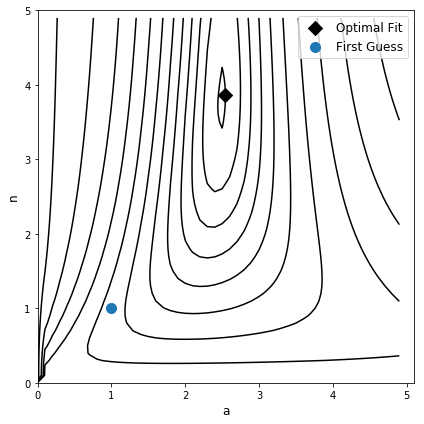

In [11]:
cp=plt.contour(EScape, levels=np.logspace(-1, 1, 15),colors="k")
plt.xlim(0,51)
plt.xticks(range(0,51,10),range(0,6));
plt.ylim(0,41)
plt.yticks(range(0,51,10),range(0,6));
plt.xlabel("a",fontsize=12)
plt.ylabel("n",fontsize=12)
plt.scatter(10*afit,10*nfit,marker="D",c="k", s=100,label="Optimal Fit")
plt.scatter(10*1,10*1, s=100,label="First Guess")
plt.legend(fontsize=12)
fig=plt.gcf()
fig.set_size_inches(6,6)
#plt.colorbar(cp)
fig.tight_layout()
#fig.savefig("Escape-hill.pdf")

## Illustrate Gradient Descent on Hill Function Optimization

In [12]:
from math import log
def fhill(x,a=1,n=1):
    return x**n/(a**n+x**n)
def Gradfhill(x,a,n):
    AX = a**n + x**n
    DEN= AX**2
    da = -(n * x**n * a**(n-1) )/DEN
    dn = (AX * x**n * log(x) - x**n *(a**n * log(a) + x**n * log(x)))/DEN
    return (da, dn)

In [13]:
def GradEhill(a,n):
    sa=0; sn=0
    for xi,yi in zip(x,y):
        da,dn = Gradfhill(xi, a,n)
        sa += 2*(fhill(xi,a,n)-yi)*da
        sn += 2*(fhill(xi,a,n)-yi)*dn
    return np.array((sa,sn))

In [14]:
GradEhill(1,1.75)

array([-3.33031584,  0.97791021])

In [15]:
Ehill(1,1.75)

2.316668267397796

In [16]:
def GD2D(f,df,x0,eta=0.001,nmax=25,conv=1E-10):
    xold=x0
    results=[]
    for i in range(nmax):
        F = f(*xold)
        DF = df(*xold)
        xnew = xold - eta * DF

        #print(i, xold, xnew)
        delta = np.linalg.norm(xnew-xold)
        if delta < conv:
            break
        results.append(xold.tolist())
        xold=xnew
    print(i,"iterations, delta=",delta)
    return(results)
U=GD2D(Ehill,GradEhill,np.array((1,1)),nmax=5000,eta=.5)


553 iterations, delta= 9.675597431945335e-11


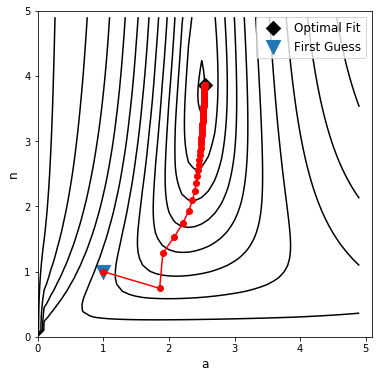

In [17]:
cp=plt.contour(EScape, levels=np.logspace(-1, 1, 15),colors="k")
plt.xlim(0,51)
plt.xticks(range(0,51,10),range(0,6));
plt.ylim(0,41)
plt.yticks(range(0,51,10),range(0,6));
plt.xlabel("a",fontsize=12)
plt.ylabel("n",fontsize=12)
plt.scatter(10*afit,10*nfit,marker="D",c="k", s=100,label="Optimal Fit")
plt.scatter(10*1,10*1, s=200,label="First Guess", marker="v")
plt.legend(fontsize=12)
fig=plt.gcf()
fig.set_size_inches(6,6)

XP,YP=zip(*U)
XP=np.array(XP); YP=np.array(YP)
plt.plot(10*XP,10*YP,marker="o", c="red")

9999 iterations, delta= 0.8006600640771757


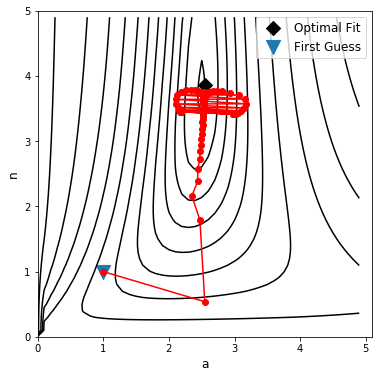

In [18]:
U=GD2D(Ehill,GradEhill,np.array((1,1)),nmax=10000,eta=.9)
cp=plt.contour(EScape, levels=np.logspace(-1, 1, 15),colors="k")
plt.xlim(0,51)
plt.xticks(range(0,51,10),range(0,6));
plt.ylim(0,41)
plt.yticks(range(0,51,10),range(0,6));
plt.xlabel("a",fontsize=12)
plt.ylabel("n",fontsize=12)
plt.scatter(10*afit,10*nfit,marker="D",c="k", s=100,label="Optimal Fit")
plt.scatter(10*1,10*1, s=200,label="First Guess", marker="v")
plt.legend(fontsize=12)
fig=plt.gcf()
fig.set_size_inches(6,6)

XP1,YP1=zip(*U)
XP1=np.array(XP1); YP1=np.array(YP1)
plt.plot(10*XP1,10*YP1,marker="o", c="red")

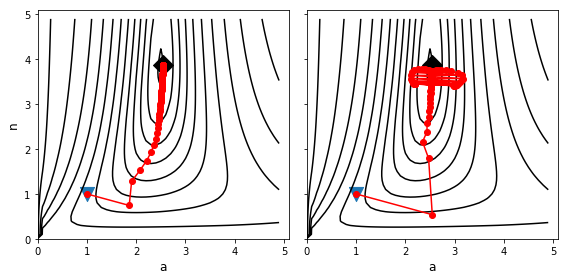

In [19]:
fig,ax=plt.subplots(nrows=1,ncols=2,sharey=True)
for j in range(2):
    ax[j].contour(EScape, levels=np.logspace(-1, 1, 15),colors="k")

    ax[j].set_xlim(0,51)
    ax[j].set_xticks(range(0,51,10))
    ax[j].set_xticklabels(range(0,6));
    ax[j].set_ylim(0,51)
    ax[j].set_yticks(range(0,51,10))
    ax[j].set_yticklabels(range(0,6));
    ax[j].set_xlabel("a",fontsize=12)
    ax[0].set_ylabel("n",fontsize=12)
    ax[j].scatter(10*afit,10*nfit,marker="D",c="k", s=200,label="Optimal Fit")
    ax[j].scatter(10*1,10*1, s=200,label="First Guess", marker="v")
#ax[0].legend(fontsize=12)
#fig=plt.gcf()
ax[0].plot(10*XP,10*YP,marker="o", c="red")
ax[1].plot(10*XP1,10*YP1,marker="o", c="red")
fig.set_size_inches(8,4)
fig.tight_layout()
fig.savefig("2D-gradient-descent.pdf")

9999 iterations, delta= 1.058058158235545


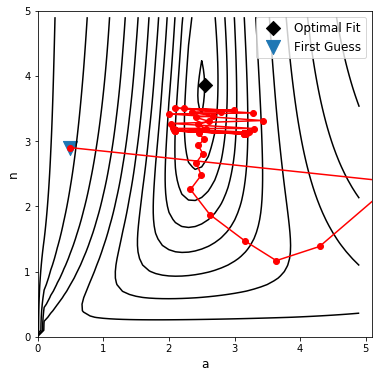

In [20]:
X0=.5; Y0=2.9
U=GD2D(Ehill,GradEhill,np.array((X0, Y0)),nmax=10000,eta=1)
cp=plt.contour(EScape, levels=np.logspace(-1, 1, 15),colors="k")
plt.xlim(0,51)
plt.xticks(range(0,51,10),range(0,6));
plt.ylim(0,41)
plt.yticks(range(0,51,10),range(0,6));
plt.xlabel("a",fontsize=12)
plt.ylabel("n",fontsize=12)
plt.scatter(10*afit,10*nfit,marker="D",c="k", s=100,label="Optimal Fit")
plt.scatter(10*X0,10*Y0, s=200,label="First Guess", marker="v")
plt.legend(fontsize=12)
fig=plt.gcf()
fig.set_size_inches(6,6)

XP2,YP2=zip(*U)
XP2=np.array(XP2); YP2=np.array(YP2)
plt.plot(10*XP2,10*YP2,marker="o", c="red")

## Population Example

In [21]:
import pandas as pd
np.exp(.3)

1.3498588075760032

In [22]:
data=pd.read_csv("us-population.txt")
X= np.array(data["Year"])
Y=np.array(data["Population"])
n=len(X)
print(data)

    Year  Population
0   1790        3929
1   1800        5308
2   1810        7239
3   1820        9638
4   1830       12866
5   1840       17069
6   1850       23191
7   1860       31433
8   1870       38558
9   1880       50189
10  1890       62979
11  1900       76212
12  1910       92228
13  1920      106021
14  1930      123202
15  1940      132164
16  1950      151325
17  1960      179323
18  1970      203302
19  1980      226542
20  1990      248709


In [23]:
def f(x,a=1,b=1):
    return np.exp(a+b*(x-1790))
parameters,covmatrix=curve_fit(f, X,Y,p0=(1,1))
a,b=parameters

siga=covmatrix[0,0]**.5
sigb=covmatrix[1,1]**.5
print("a=",round(a,3),"+/-",round(1.96*siga,3))
print("b=",round(b,3),"+/-",round(1.96*sigb,3))

#print("covmatrix=",covmatrix)
lsfit=f(X,*parameters)
print("MSE=",sum((Y-lsfit)**2)/n)

a= 9.548 +/- 0.201
b= 0.015 +/- 0.001
MSE= 90900652.15033811


In [24]:
M,B=np.polyfit(X,np.log(Y),1)
print("slope =   ",round(M,3))
print("intercept=",round(B,3))
logfit=np.exp(M*X+B)
print("MSE =     ",sum((Y-logfit)**2)/n)

slope =    0.021
intercept= -28.505
MSE =      1193297724.9124706


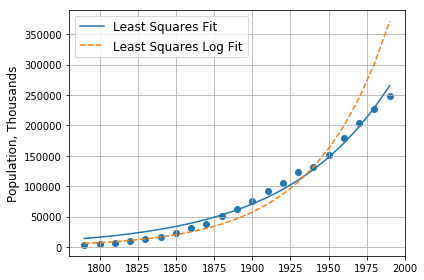

In [25]:
plt.scatter(X,Y)
plt.plot(X,lsfit,label="Least Squares Fit")
plt.plot(X,logfit, ls="--", label="Least Squares Log Fit")
plt.legend(fontsize=12)
plt.ylabel("Population, Thousands", fontsize=12)
#plt.yscale("log")
plt.grid()
plt.gcf().tight_layout()
plt.gcf().savefig("US-Population-Two-Fits.pdf")

In [26]:
1193297724.9124706/90900652.15033811

13.127493551299368

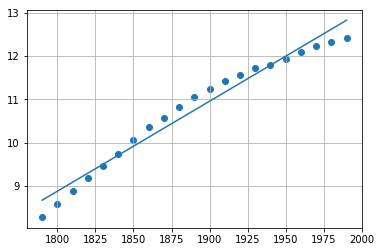

In [27]:
plt.scatter(X,np.log(Y))
plt.plot(X,M*X+B)
plt.grid()


In [28]:
f(3,4,5)

0.0

## ONE D Gradient Descent Example

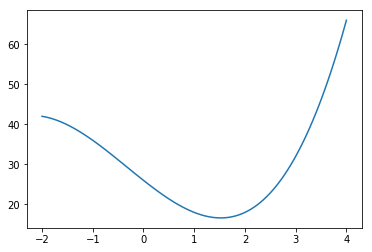

In [29]:
def f(x):
    return((x-5)**2 + x**3+1)
def df(x):
    return(2*(x-5)+3*x**2)
def d2f(x):
    return(2+6*x)
xplot=np.linspace(-2,4,100)
yplot=f(xplot)
plt.plot(xplot,yplot)

3220 iterations, delta= 9.990253069247501e-11


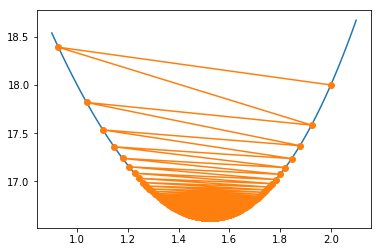

In [30]:
def gradient_descent(f,df,x0,eta=0.001,nmax=25,conv=1E-10):
    xold=x0
    results=[]
    for i in range(nmax):
        F = f(xold)
        DF = df(xold)
        #print(i, F, DF)
        xnew = xold - eta * DF
        delta = abs(xnew-xold)
        if delta < conv:
            break
        results.append([xold, F])
        xold=xnew
    print(i,"iterations, delta=",delta)
    return(results)
U=gradient_descent(f,df,2,nmax=100000,eta=.179)
XP,YP=zip(*U)
xplot=np.linspace(.9, 2.1,100)
yplot=f(xplot)
plt.plot(xplot,yplot)
plt.plot(XP,YP,marker="o")

106 iterations, delta= 8.229839032480868e-11


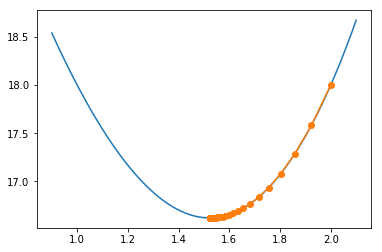

In [31]:
def quasi_newton(f,df,d2f, x0,eta=0.2,nmax=25,conv=1E-10):
    xold=x0
    results=[]

    for i in range(nmax):
        F = f(xold)
        DF = df(xold)
        DF2 = d2f(xold)

        xnew = xold - eta * DF/abs(DF2)
        #print(i,DF,  xold, xnew)
        delta = abs(xnew-xold)
        if delta < conv:
            break
        results.append([xold, F])
        xold=xnew
    print(i,"iterations, delta=", delta)
    return(results)
U=quasi_newton(f,df,d2f, 2,nmax=1000,eta=.179)
XP2,YP2=zip(*U)
xplot=np.linspace(.9,2.1,100)
yplot=f(xplot)
plt.plot(xplot,yplot)
plt.plot(XP2,YP2,marker="o")

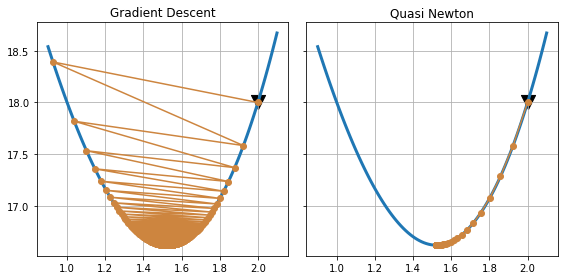

In [32]:
fig, ax=plt.subplots(nrows=1,ncols=2,sharey=True)
x0=2
y0=f(x0)
xplot=np.linspace(.9, 2.1,100)
yplot=f(xplot)
ax[0].plot(xplot,yplot,lw=3)
ax[0].plot(XP,YP,marker="o",c="Peru")
ax[0].scatter([x0],[y0],c="k",s=200,marker="v")

ax[0].grid()
ax[1].plot(xplot,yplot,lw=3)
ax[1].plot(XP2,YP2,marker="o",c="Peru")
ax[1].scatter([x0],[y0],c="k",s=200,marker="v")

ax[1].grid()

ax[0].set_title("Gradient Descent")
ax[1].set_title("Quasi Newton")
fig.set_size_inches(8,4)

fig.tight_layout()

fig.savefig("gradient-descent-example.pdf")